In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path='/content/drive/MyDrive/2022_Battery_Data/'


In [3]:
target_property_list = ['voltage', 'energy', 'conductivity', 'columbic Efficiency']
gnn_data = pd.read_csv(f'{path}data0.csv')
textemb_data = pd.read_csv(f'{path}embeddings_matbert-base-cased_robo_75966 (1).csv')
textemb_data.rename(columns={'Unnamed: 0': 'id'}, inplace=True)

merging graph and text

In [4]:
 #Ensure id is string type for merge
gnn_data['id'] = gnn_data['id'].astype(str)
textemb_data['id'] = textemb_data['id'].astype(str)

# Merge embeddings on 'id' to create a joint multimodal embedding
joint_emb_data = pd.merge(gnn_data, textemb_data, on='id', suffixes=('_gnn', '_text'))


# Initialize R² storage
r2_scores = {
    "Linear Regression": [],
    "MLP Regressor": [],
    "Random Forest Regressor": [],
    "KNN Regressor": [],
    "Decision Tree Regressor": []
}
mae_scores = {
    "Linear Regression": [],
    "MLP Regressor": [],
    "Random Forest Regressor": [],
    "KNN Regressor": [],
    "Decision Tree Regressor": []
}
#valid_target_properties_joint = []
valid_target_properties = []

In [5]:
## K means evaluation (k=10)
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error
kf = KFold(n_splits=10, shuffle=False)

for target_property in target_property_list:
    print(f"STARTING PROPERTY {target_property.upper()}")
    try:
        df1 = pd.read_excel(f'{path}{target_property}.xlsx')
    except Exception as e:
        print(f"Failed to load data for {target_property}: {e}")
        continue

    avg_df = df1.groupby('jid')['Value'].mean().reset_index()
    avg_df = avg_df[avg_df['jid'].astype(str).str.startswith('JVASP')]

    merged_df = pd.merge(avg_df, joint_emb_data, left_on='jid', right_on='id')
    merged_df = merged_df[merged_df['jid'] == merged_df['id']].dropna()

    # Ensure enough data
    if merged_df.shape[0] < 10:
        print(f"Skipping {target_property} due to insufficient data ({merged_df.shape[0]} rows).")
        continue

    # Extract features and target
    X = merged_df.drop(columns=['Value', 'id', 'jid'])
    X = X.select_dtypes(include=[np.number])  # only numeric features
    y = merged_df['Value'].values

    if X.shape[0] != len(y):
        print(f"Skipping {target_property} due to X/y shape mismatch.")
        continue

    # Normalize features for MLP/KNN
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Store valid target property for plotting
    valid_target_properties.append(target_property)

    # Train and evaluate models
    models = {
        "Linear Regression": LinearRegression(),
        "MLP Regressor": MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=10000, random_state=42),
        "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
        "KNN Regressor": KNeighborsRegressor(n_neighbors=5),
        "Decision Tree Regressor": DecisionTreeRegressor(random_state=42)
    }

    for name, model in models.items():
        print(f"Starting model {name}")
        fold_r2_accuracies = []
        fold_mae_accuracies = []

        for fold, (train_index, test_index) in enumerate(kf.split(X)):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]


            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)
            fold_r2_accuracies.append(r2)

            mae = mean_absolute_error(y_test, y_pred)
            fold_mae_accuracies.append(mae)

            # print(f"Completed fold {fold} with MAE {mae}")

        mae_scores[name].append(np.average(fold_mae_accuracies))
        r2_scores[name].append(np.average(fold_r2_accuracies))

        print(f"Finished property {name} with average MAE {np.average(fold_mae_accuracies)}")


STARTING PROPERTY VOLTAGE
Starting model Linear Regression
Finished property Linear Regression with average MAE 0.9354476477340047
Starting model MLP Regressor
Finished property MLP Regressor with average MAE 0.6570647806441339
Starting model Random Forest Regressor
Finished property Random Forest Regressor with average MAE 0.6026882239860145
Starting model KNN Regressor
Finished property KNN Regressor with average MAE 0.6139236325078151
Starting model Decision Tree Regressor
Finished property Decision Tree Regressor with average MAE 0.8768184496998019
STARTING PROPERTY ENERGY
Starting model Linear Regression
Finished property Linear Regression with average MAE 660.5685311052426
Starting model MLP Regressor
Finished property MLP Regressor with average MAE 513.9844724012281
Starting model Random Forest Regressor
Finished property Random Forest Regressor with average MAE 477.16053024329614
Starting model KNN Regressor
Finished property KNN Regressor with average MAE 465.82975825667444
St

In [6]:
valid_target_properties=['Voltage','Energy','Conductivity','Columbic Efficiency']

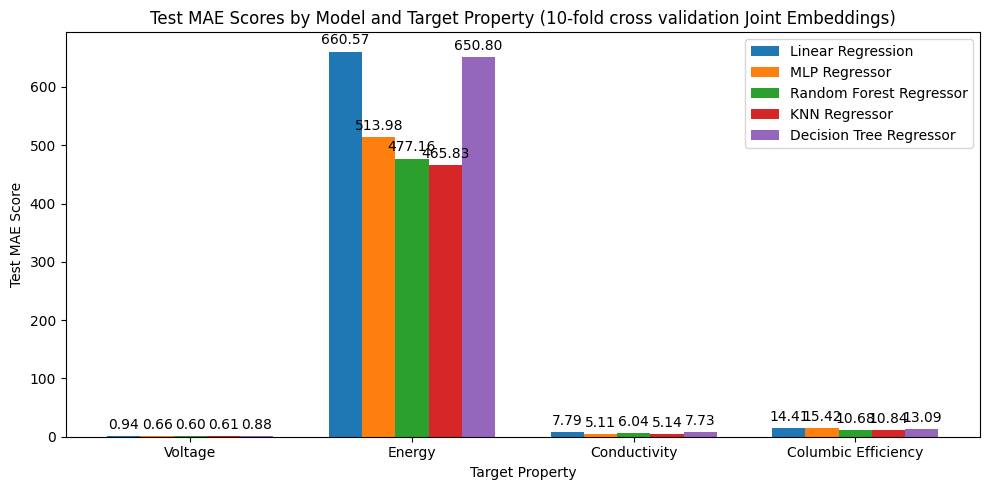

In [7]:
plt.rcParams.update({'font.size': 10})
x = np.arange(len(valid_target_properties))
width = 0.15
fig, ax = plt.subplots(figsize=(10, 5))

def split_scores(scores):
    """Return (valid_scores, invalid_flags)"""
    visible = [v if v >= 0 else 0 for v in scores]
    invalid_flags = [v < 0 for v in scores]
    return visible, invalid_flags

def plot_model(ax, offset, scores, label, color):
    visible, is_invalid = split_scores(scores)
    rects_visible = ax.bar(x + offset, visible, width, label=label, color=color)

    # Draw hatched rectangles for invalid scores at fixed height
    hatch_height = 0.05  # fixed height for placeholder
    for i, invalid in enumerate(is_invalid):
        if invalid:
            ax.bar(x[i] + offset, hatch_height, width,
                   fill=False, hatch='//', edgecolor=color, linewidth=1)

    return rects_visible

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

rects1 = plot_model(ax, -2*width, mae_scores["Linear Regression"][-4:], 'Linear Regression', colors[0])
rects2 = plot_model(ax, -width, mae_scores["MLP Regressor"][-4:], 'MLP Regressor', colors[1])
rects3 = plot_model(ax, 0, mae_scores["Random Forest Regressor"][-4:], 'Random Forest Regressor', colors[2])
rects4 = plot_model(ax, width, mae_scores["KNN Regressor"][-4:], 'KNN Regressor', colors[3])
rects5 = plot_model(ax, 2*width, mae_scores["Decision Tree Regressor"][-4:], 'Decision Tree Regressor', colors[4])

# Format axes
ax.set_xlabel('Target Property')
ax.set_ylabel('Test MAE Score')
ax.set_title('Test MAE Scores by Model and Target Property (10-fold cross validation Joint Embeddings)')
ax.set_xticks(x)
ax.set_xticklabels([prop.title() for prop in target_property_list], rotation=0, ha='center')
ax.legend()
# ax.set_ylim(0, 0.8)  # Set max height to 0.8

# Annotate only positive R² values
def add_annotations(rects):
    for rect in rects:
        height = rect.get_height()
        if height >= 0.01:
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

for rect_set in [rects1, rects2, rects3, rects4, rects5]:
    add_annotations(rect_set)

fig.tight_layout()
plt.show()

[0 1 2 3] -0.3 [np.float64(0.9354476477340047)] 0.15 Linear Regression tab:blue
<BarContainer object of 1 artists>
[0 1 2 3] -0.15 [np.float64(0.6570647806441339)] 0.15 MLP Regressor tab:orange
<BarContainer object of 1 artists>
[0 1 2 3] 0 [np.float64(0.6026882239860145)] 0.15 Random Forest Regressor tab:green
<BarContainer object of 1 artists>
[0 1 2 3] 0.15 [np.float64(0.6139236325078151)] 0.15 KNN Regressor tab:red
<BarContainer object of 1 artists>
[0 1 2 3] 0.3 [np.float64(0.8768184496998019)] 0.15 Decision Tree Regressor tab:purple
<BarContainer object of 1 artists>


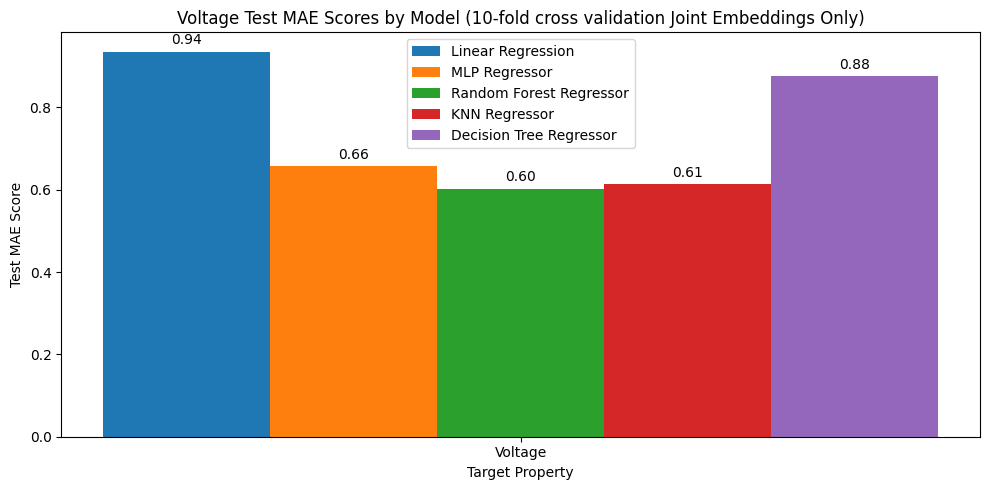

In [8]:
plt.rcParams.update({'font.size': 10})
x = np.arange(len(valid_target_properties))
width = 0.15
fig, ax = plt.subplots(figsize=(10, 5))

def split_scores(scores):
    """Return (valid_scores, invalid_flags)"""
    visible = [v if v >= 0 else 0 for v in scores]
    invalid_flags = [v < 0 for v in scores]
    return visible, invalid_flags

def plot_model(ax, offset, scores, label, color):
    visible, is_invalid = split_scores([scores[0]])
    rects_visible = ax.bar(x[0] + offset, visible, width, label=label, color=color)
    print(x, offset, visible, width, label, color)
    print(rects_visible)

    # Draw hatched rectangles for invalid scores at fixed height
    # hatch_height = 0.05  # fixed height for placeholder
    # for i, invalid in enumerate(is_invalid):
    #     if invalid:
    #         ax.bar(x[i] + offset, hatch_height, width,
    #                fill=False, hatch='//', edgecolor=color, linewidth=1)

    return rects_visible

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

rects1 = plot_model(ax, -2*width, mae_scores["Linear Regression"][-4:], 'Linear Regression', colors[0])
rects2 = plot_model(ax, -width, mae_scores["MLP Regressor"][-4:], 'MLP Regressor', colors[1])
rects3 = plot_model(ax, 0, mae_scores["Random Forest Regressor"][-4:], 'Random Forest Regressor', colors[2])
rects4 = plot_model(ax, width, mae_scores["KNN Regressor"][-4:], 'KNN Regressor', colors[3])
rects5 = plot_model(ax, 2*width, mae_scores["Decision Tree Regressor"][-4:], 'Decision Tree Regressor', colors[4])

# Format axes
ax.set_xlabel('Target Property')
ax.set_ylabel('Test MAE Score')
ax.set_title('Voltage Test MAE Scores by Model (10-fold cross validation Joint Embeddings Only)')
ax.set_xticks([0])

ax.set_xticklabels(['Voltage'], rotation=0, ha='center')
ax.legend()
# ax.set_ylim(0, 0.8)  # Set max height to 0.8

# Annotate only positive R² values
def add_annotations(rects):
    for rect in rects:
        height = rect.get_height()
        if height >= 0.01:
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

for rect_set in [rects1, rects2, rects3, rects4, rects5]:
    add_annotations(rect_set)

fig.tight_layout()
plt.show()

In [6]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=False)
target_property = "voltage"
df1 = pd.read_excel(f'{path}{target_property}.xlsx')
avg_df = df1.groupby('jid')['Value'].mean().reset_index()
avg_df = avg_df[avg_df['jid'].astype(str).str.startswith('JVASP')]

merged_df = pd.merge(avg_df, joint_emb_data, left_on='jid', right_on='id')
merged_df = merged_df[merged_df['jid'] == merged_df['id']].dropna()
X = merged_df.drop(columns=['Value', 'id', 'jid'])
X = X.select_dtypes(include=[np.number])  # only numeric features
y = merged_df['Value'].values


# Normalize features for MLP/KNN
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Store valid target property for plotting
valid_target_properties.append(target_property)

In [7]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'criterion': ['absolute_error']
}
# === RandomizedSearchCV to find best params ===
search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=42,
    n_jobs=-1,
    error_score='raise'
)
search.fit(X, y)
best_params = search.best_params_
print("Best Parameters:", best_params)

# === Cross-validation using best model ===
best_model = RandomForestRegressor(**best_params, random_state=42)

fold_mae_accuracies = []
fold_r2_accuracies = []




Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30, 'criterion': 'absolute_error', 'bootstrap': False}


NameError: name 'mean_absolute_error' is not defined

In [8]:
from sklearn.metrics import r2_score, mean_absolute_error
for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    fold_mae_accuracies.append(mae)
    fold_r2_accuracies.append(r2)

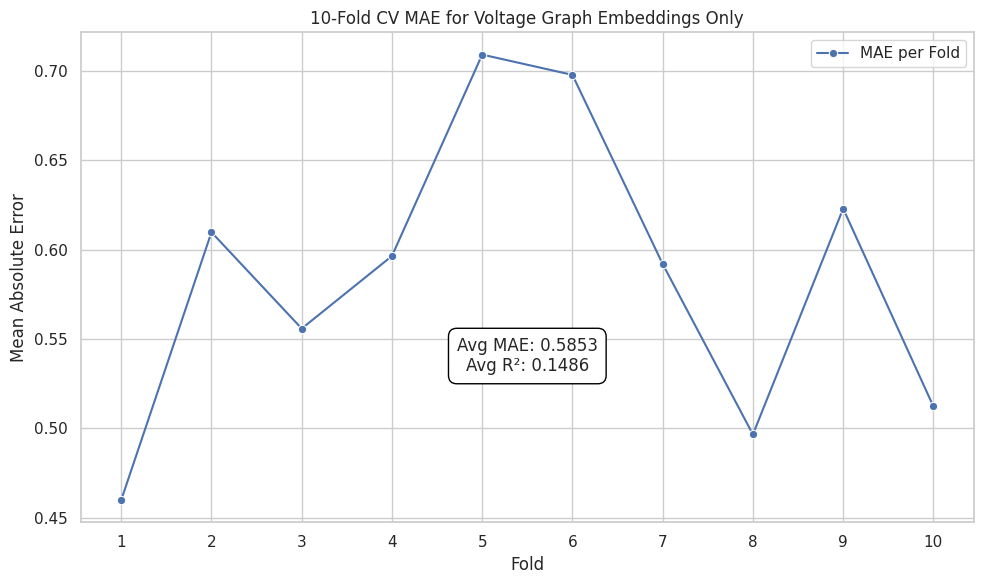

In [9]:
import seaborn as sns
# === Plot MAE per fold ===
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, 11), y=fold_mae_accuracies, marker='o', label='MAE per Fold')
plt.title(f"10-Fold CV MAE for Voltage Graph Embeddings Only")
plt.xlabel("Fold")
plt.ylabel("Mean Absolute Error")
plt.xticks(range(1, 11))

# === Add result box without using patches ===
box_text = f"Avg MAE: {np.mean(fold_mae_accuracies):.4f}\nAvg R²: {np.mean(fold_r2_accuracies):.4f}"
xpos = 5.5
ypos = max(fold_mae_accuracies) * 0.75
plt.text(
    xpos, ypos, box_text,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'),
    ha='center'
)

plt.legend()
plt.tight_layout()
plt.show()

In [10]:
best_params

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 30,
 'criterion': 'absolute_error',
 'bootstrap': False}

In [11]:
fold_mae_accuracies

[0.45995475607237546,
 0.6097873115843624,
 0.5558831323511516,
 0.5964857223234061,
 0.709200602430729,
 0.6978510779802596,
 0.5920038353959896,
 0.49662914434144434,
 0.6230148281710446,
 0.5123209408867182]

In [12]:
from sklearn.model_selection import cross_val_score
results = search.cv_results_
results_df = pd.DataFrame(results, columns=['params', 'mean_test_score'])

# Convert to positive MAE
results_df.rename(columns={'mean_test_score': 'mean_score'}, inplace=True)
results_df['mean_score'] = -results_df['mean_score']  # Convert from negative MAE to actual MAE

# Flatten the params dictionary for visualization
params_df = pd.json_normalize(results_df['params'])
results_df = pd.concat([results_df.drop('params', axis=1), params_df], axis=1)

In [13]:
results_df

,mean_score,n_estimators,min_samples_split,min_samples_leaf,max_features,max_depth,criterion,bootstrap
0,0.601315,200,5,1,sqrt,30.0,absolute_error,True
1,0.591234,200,5,4,sqrt,30.0,absolute_error,False
2,0.613421,500,2,2,None,20.0,absolute_error,True
3,0.597673,500,2,4,log2,30.0,absolute_error,True
4,0.592289,200,10,4,log2,10.0,absolute_error,False
5,0.821783,200,5,2,None,50.0,absolute_error,False
6,0.608773,100,2,2,log2,20.0,absolute_error,True
7,0.609899,500,2,1,log2,20.0,absolute_error,False
8,0.616044,200,5,4,None,30.0,absolute_error,True
9,0.600448,500,2,1,sqrt,20.0,absolute_error,False


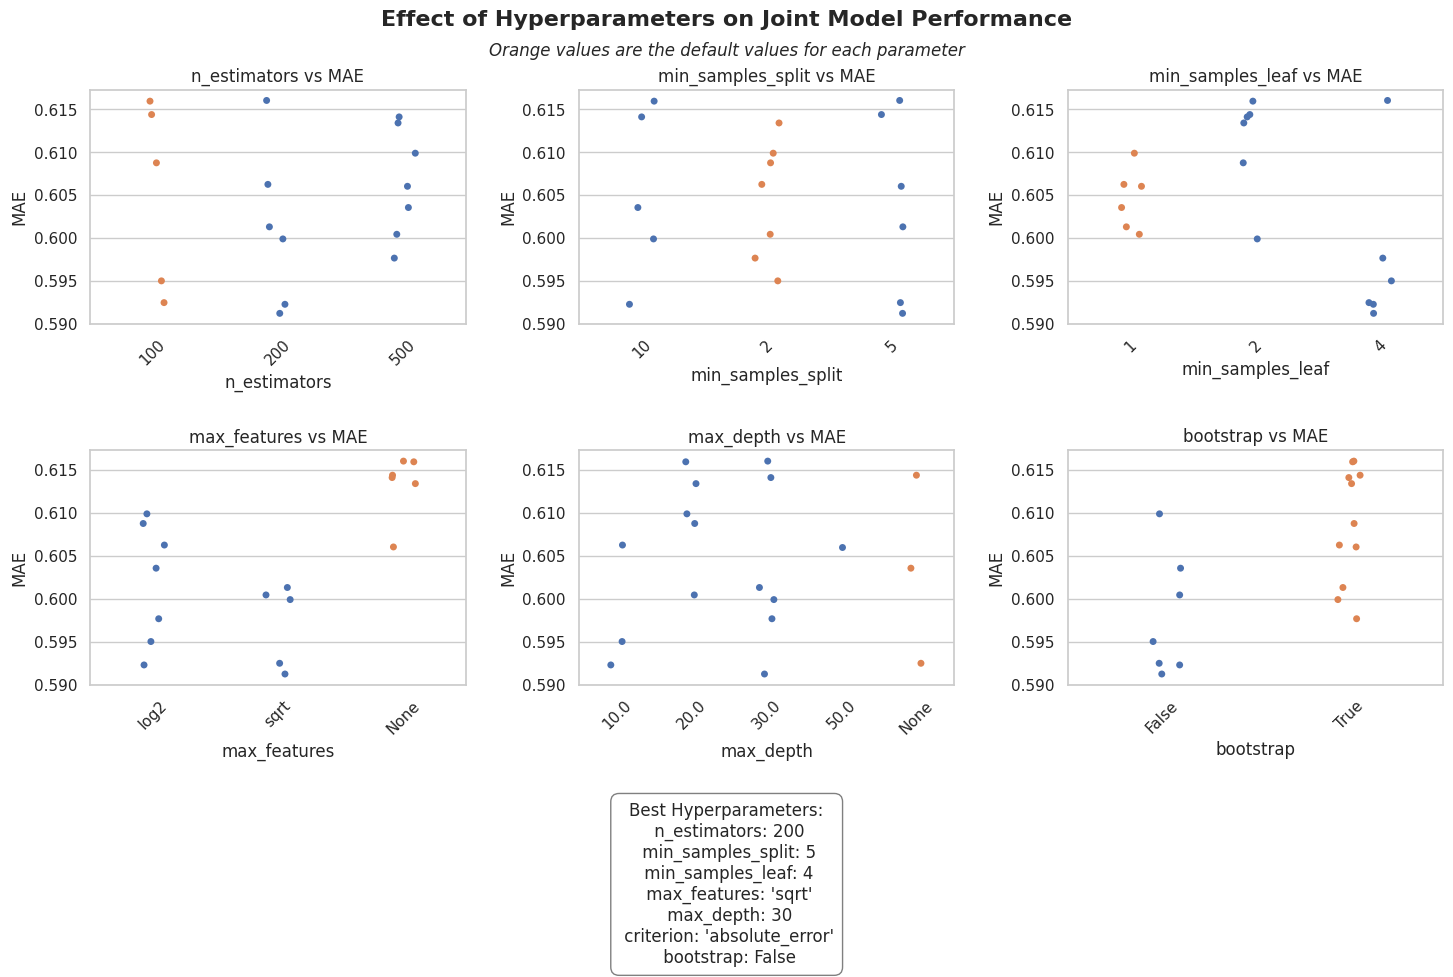

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get the default features
default_model = RandomForestRegressor()
defaults = default_model.get_params()
defaults['max_features'] = 'None'

# Filter out outliers with high MAEs for clear visualization
filtered_df = results_df[results_df['mean_score'] <= 0.75].copy()

# Drop only the score column; include all params
param_columns = [col for col in results_df.columns if col != "mean_score" and col != 'criterion']

# Convert all param columns to string for consistent plotting
plot_df = filtered_df.copy()
for col in param_columns:
    plot_df[col] = plot_df[col].astype(str).replace("nan", "None")

# Set up subplot grid
n_cols = 3
n_rows = (len(param_columns) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

# Plot each parameter vs. mean_score
for i, param in enumerate(param_columns):

    default_value = str(defaults[param])
    plot_df['is_default'] = plot_df[param] == default_value

    ordering = sorted(plot_df[param].unique(), key=lambda x: (x == "nan" or x == "None", x)) # put the nan values at the end
    sns.stripplot(data=plot_df, x=param, y='mean_score', ax=axes[i], order=ordering, jitter=True, hue='is_default', legend=False)
    axes[i].set_title(f"{param} vs MAE")
    # axes[i].set_xlabel(param)
    axes[i].set_ylabel("MAE")
    axes[i].tick_params(axis='x', rotation=45)

fig.suptitle("Effect of Hyperparameters on Joint Model Performance", fontsize=16, fontweight='bold')
fig.text(0.5, 0.94, "Orange values are the default values for each parameter", ha='center', va='top', fontsize=12, style='italic')
best_params_str = "\n".join(
    f" {k}: {repr(v)}" for k, v in search.best_params_.items()
)

# Add a textbox at the bottom center
fig.text(
    0.5, -0.01, f"Best Hyperparameters:\n{best_params_str}",
    ha='center', va='top', fontsize=12, bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="gray")
)
plt.tight_layout(pad=2.0)
plt.subplots_adjust(top=0.88)
plt.show()

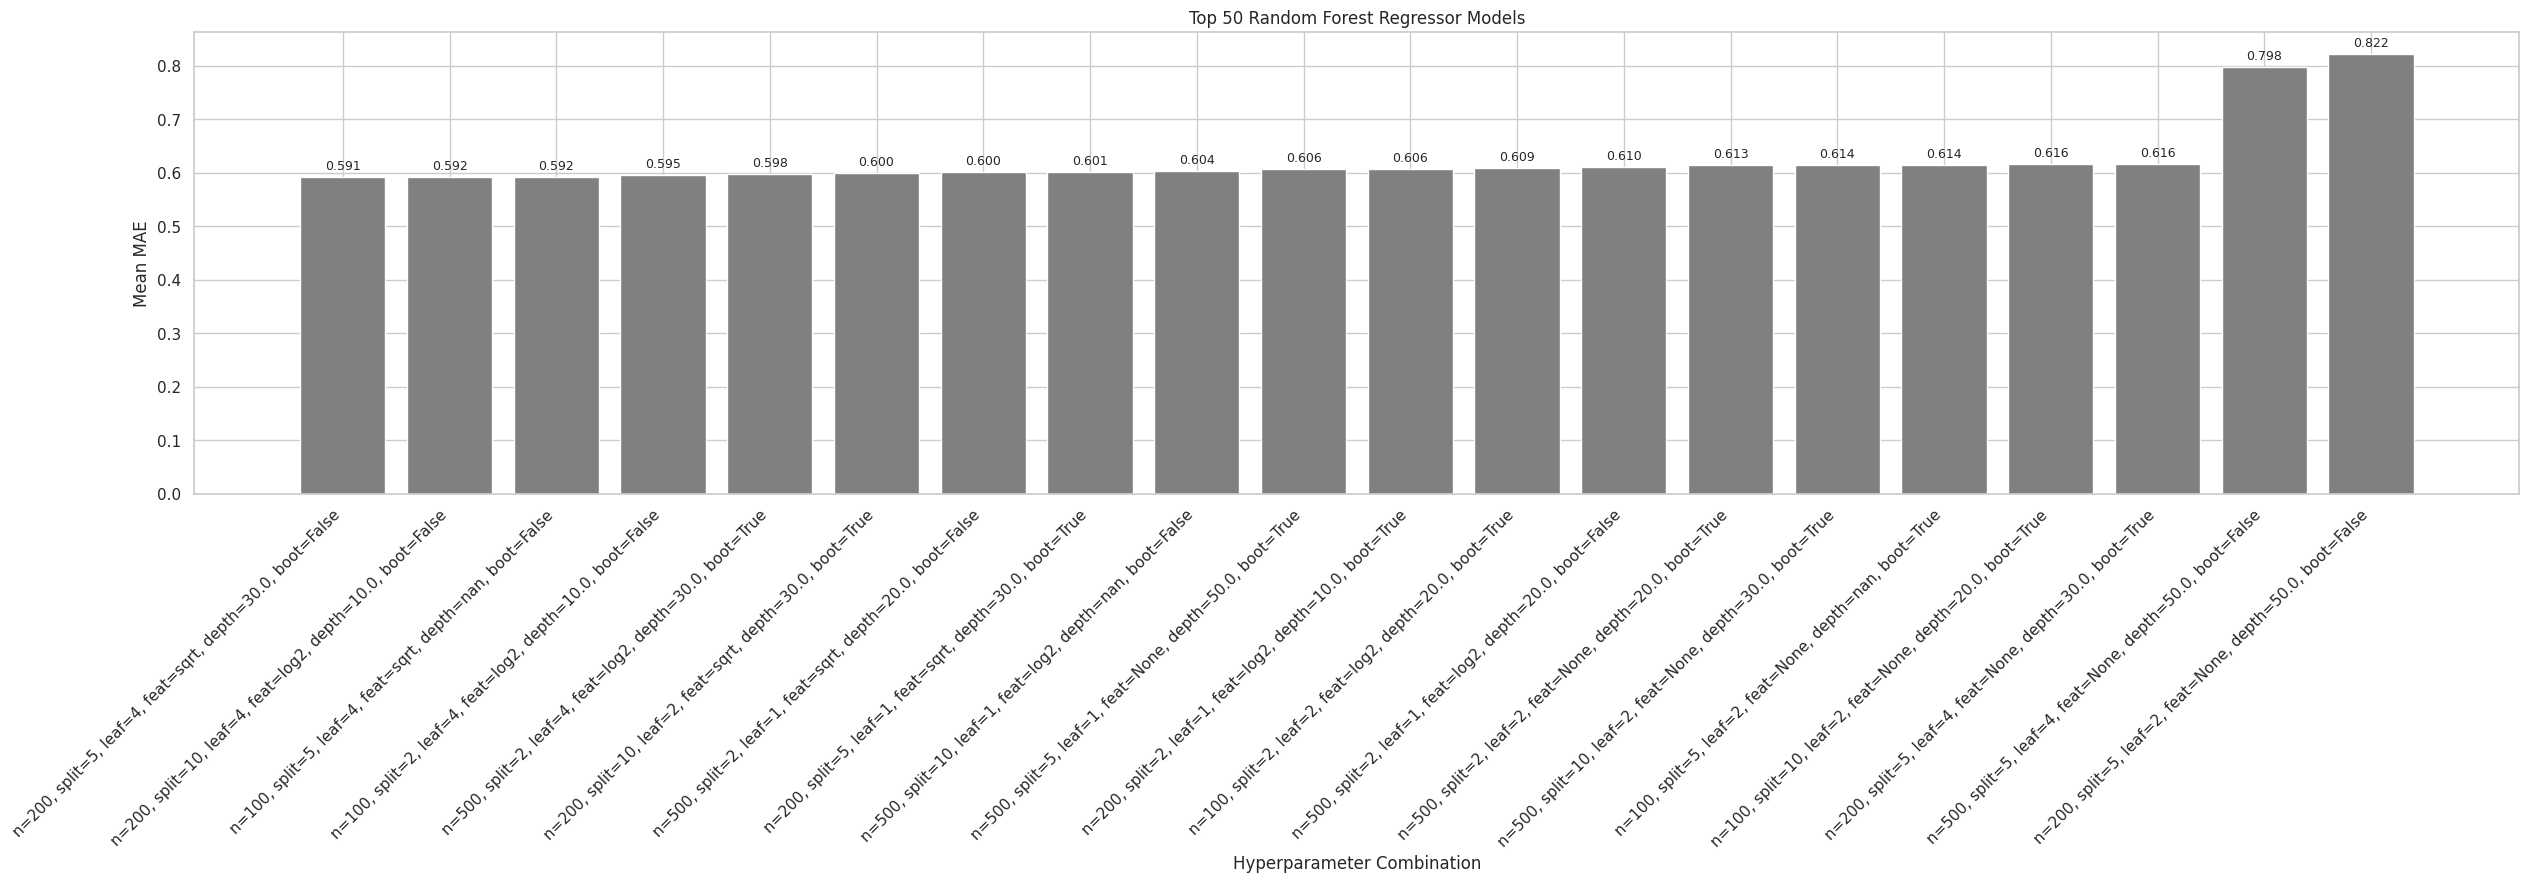

In [17]:
import matplotlib.pyplot as plt



# Sort and select top N models
top_n = 50
plot_df = results_df.sort_values("mean_score").head(top_n).copy()

# Create readable labels
plot_df["params_str"] = plot_df.apply(
    lambda row: f"n={row.n_estimators}, split={row.min_samples_split}, leaf={row.min_samples_leaf}, feat={row.max_features}, depth={row.max_depth}, boot={row.bootstrap}",
    axis=1
)

# Plot
fig, ax = plt.subplots(figsize=(30, 6))
bars = ax.bar(plot_df["params_str"], plot_df["mean_score"], color="gray")

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01 * max(plot_df["mean_score"]),
        f"{height:.3f}",
        ha='center',
        va='bottom',
        fontsize=9
    )

# Labels and layout
ax.set_ylabel("Mean MAE")
ax.set_xlabel("Hyperparameter Combination")
ax.set_title(f"Top {top_n} Random Forest Regressor Models")
plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
plt.show()